# EMA

/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_45225/1373307969.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer['sell_price'].interpolate(method='linear', inplace=True)


adf:  -12.041152488931608
p-value:  2.730292178314811e-22
Critical values:  {'1%': -3.433966009459769, '5%': -2.8631372667825503, '10%': -2.567620331903232}
единичных корней нет, ряд стационарен


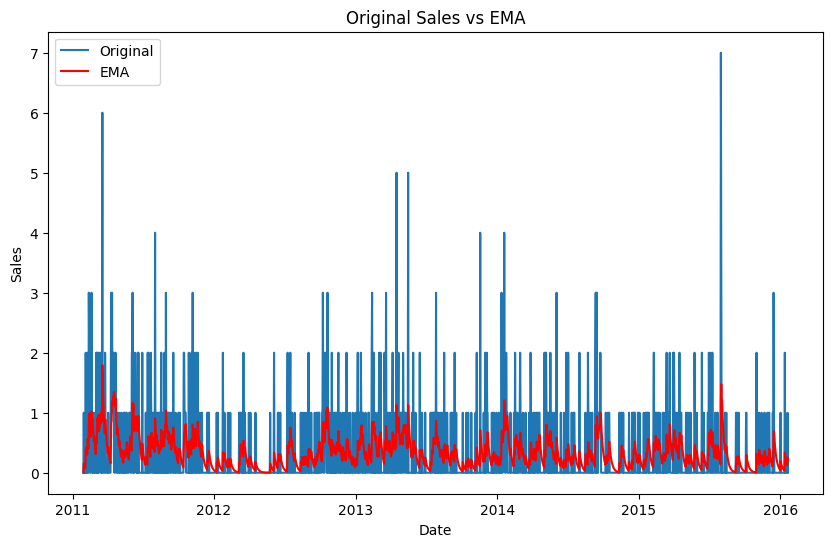

Mean Squared Error (EMA): 0.3416360744560618
Mean Absolute Error (EMA): 0.4021893090116507


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Загрузка данных
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

# Подготовка данных
sales_data['week_id'] = (sales_data['date_id'] - 1) // 7 + 11101
merged_data = pd.merge(sales_data, prices_data, how='left', 
                       left_on=['store_id', 'item_id', 'week_id'], 
                       right_on=['store_id', 'item_id', 'wm_yr_wk'])
merged_data.drop(columns=['wm_yr_wk'], inplace=True)

# Выбор данных для конкретного магазина и товара
store_id = 'STORE_1'
item_id = 'STORE_1_064'
customer = merged_data[(merged_data['store_id'] == store_id) & (merged_data['item_id'] == item_id)]
customer = pd.merge(customer, calendar_data, on='date_id', how='inner')
customer = customer.rename(columns={'date': 'ds', 'cnt': 'y'})
customer['ds'] = pd.to_datetime(customer['ds'])
customer.set_index('ds', inplace=True)

# Заполнение пропущенных значений в sell_price
customer['sell_price'].interpolate(method='linear', inplace=True)

# Проверка стационарности ряда
test = sm.tsa.adfuller(customer['y'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')
    
if test[0] > test[4]['5%']:
    customer['y_diff'] = customer['y'].diff().dropna()
else:
    customer['y_diff'] = customer['y']

# Проверка стационарности после дифференцирования
if test[0] > test[4]['5%']:
    test_diff = sm.tsa.adfuller(customer['y_diff'].dropna())
    print('adf (after differencing): ', test_diff[0])
    print('p-value (after differencing): ', test_diff[1])
    print('Critical values (after differencing): ', test_diff[4])
    
    if test_diff[0] > test_diff[4]['5%']:
        print('есть единичные корни, ряд не стационарен после дифференцирования')
    else:
        print('единичных корней нет, ряд стационарен после дифференцирования')
        
    if test[0] > test[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
        customer['y_diff'] = customer['y'].diff().dropna()
        data_to_plot = customer['y_diff']
    else:
        print('единичных корней нет, ряд стационарен')
        data_to_plot = customer['y']
# Добавление экспоненциального скользящего среднего (EMA)
customer['ema'] = customer['y'].ewm(span=12, adjust=False).mean()

# Визуализация исходных данных и EMA
plt.figure(figsize=(10, 6))
plt.plot(customer.index, customer['y'], label='Original')
plt.plot(customer.index, customer['ema'], label='EMA', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Sales vs EMA')
plt.legend()
plt.show()

# Оценка качества модели EMA
mse_ema = mean_squared_error(customer['y'], customer['ema'])
mae_ema = mean_absolute_error(customer['y'], customer['ema'])
print(f'Mean Squared Error (EMA): {mse_ema}')
print(f'Mean Absolute Error (EMA): {mae_ema}')

